In [1]:
from skimage import io
import pandas as pd
from skimage.transform import rotate, resize, rescale
from skimage.util import pad, invert, img_as_float
import random
import numpy as np
from skimage import io

#df = pd.DataFrame.from_csv("data_set.csv")

def normalize_shape(img):
    max_shape = (200,200)
    normalized = []
    if img.shape[0] < max_shape[0] and img.shape[1] < max_shape[1]:
        normalized = pad_to_size(img, max_shape)
    else:
        normalized = rescale(img, min(np.divide(max_shape, img.shape)))
        normalized = pad_to_size(normalized, max_shape)
    if normalized.shape != max_shape:
        print(normalized.shape)
    return normalized.reshape(200,200,1)

def pad_to_size(img, size):
    h, w = img.shape
    p_up = int((size[0] - h)/2) +1
    p_left = int((size[1] - w)/2) + 1
    return pad(img, ((p_up,p_up),(p_left,p_left)), 'constant', constant_values=(0.0, 0.0))[0:size[0],0:size[1]]    

def load_file(path):
    img = io.imread(path)
    img = img_as_float(img)    
    return normalize_shape(img)




In [2]:
df = pd.DataFrame.from_csv("validation_set.csv")
for idx, row in df.iterrows():
    if idx % 1000 == 0:
        print("sample {}/{}".format(idx, len(df)))
    df.set_value(idx, "left", load_file(row["left"]))
    df.set_value(idx, "right", load_file(row["right"]))


sample 0/3630


/home/sirpawel/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


sample 1000/3630
sample 2000/3630
sample 3000/3630


In [ ]:
from keras.layers import Input, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, concatenate, BatchNormalization, Activation
from keras.losses import hinge
import keras.backend as K
from keras.models import Model
from keras import optimizers
import csv
INPUT_SHAPE = (200,200,1)




def generate_arrays_from_file(path, batch_size):
    i = 0
    l = []
    r = []
    y_s = []
    while True:
        with open('data_set.csv', newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            next(reader, None)
            for row in reader:
                if i % batch_size:
                    yield [np.array(l), np.array(r)], np.array(y_s)
                    l = []
                    r = []
                    y_s = []
                
                l.append(load_file(row[1]))
                r.append(load_file(row[2]))
                y_s.append(int(row[3]))
                i+=1


img_in = Input(shape=INPUT_SHAPE)
n_layer = img_in
for i in range(2):
    n_layer = Conv2D(8*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = Conv2D(16*2**i, kernel_size = (3,3), activation = 'linear')(n_layer)
    n_layer = BatchNormalization()(n_layer)
    n_layer = Activation('relu')(n_layer)
    n_layer = MaxPooling2D((2,2))(n_layer)

n_layer = Flatten()(n_layer)
n_layer = Dense(32, activation = 'linear')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Activation('relu')(n_layer)
feature_model = Model(inputs = [img_in], outputs = [n_layer])



x_l_input = Input(shape=INPUT_SHAPE)
x_r_input = Input(shape=INPUT_SHAPE)

x_l_feat = feature_model(x_l_input)
x_r_feat = feature_model(x_r_input)


merged_vector = concatenate([x_l_feat, x_r_feat], axis=-1)

merged_vector = Dense(128, activation = "relu")(merged_vector)
merged_vector = Dropout(0.5)(merged_vector)

merged_vector = Dense(64, activation = "relu")(merged_vector)
merged_vector = Dropout(0.5)(merged_vector)

prediction = Dense(1, activation = "sigmoid")(merged_vector)

model = Model(inputs=[x_l_input,x_r_input], outputs=prediction)
model.compile(optimizer="adadelta",
              loss="binary_crossentropy",
              metrics=['accuracy'])

model.summary()


X = np.array(list(zip(df["left"].values,df["right"].values)))
Y = df["y"].values
X_val_right = np.array( X[:,1])
X_val_left = np.array(X[:,0])

trained_model = model.fit_generator(
    generate_arrays_from_file('data_set.csv', 64),
    steps_per_epoch=int(2114497/64),
    epochs=30,
    validation_data = ([X_val_left, X_val_right],Y))



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 200, 200, 1)  0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 32)           2270672     input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 64)           0           model_7[1][0]                    
          

/home/sirpawel/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


33039/33039 [==============================] - 668s 20ms/step - loss: 0.6813 - acc: 0.6578 - val_loss: 2.6886 - val_acc: 0.8331
Epoch 2/30
33039/33039 [==============================] - 666s 20ms/step - loss: 0.6941 - acc: 0.6539 - val_loss: 2.6797 - val_acc: 0.8331
Epoch 3/30
 7705/33039 [=====>........................] - ETA: 8:16 - loss: 0.6957 - acc: 0.6493

Train set accuracy score = 0.831547838936
Train set recall score = 0.414634146341
Train set precission score = 1.0
Test set accuracy score = 0.751107828656
Test set recall score = 0.126943005181
Test set precission score = 1.0


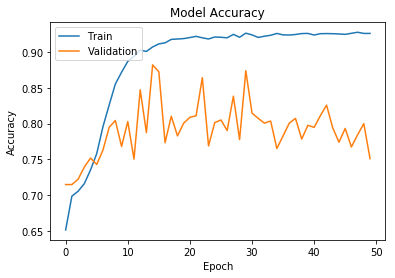

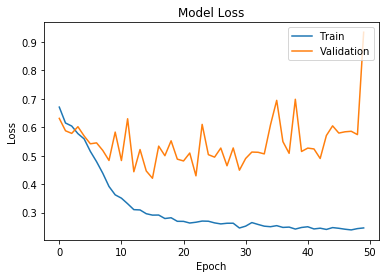

In [164]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt

# eval train
predict_train = np.array(model.predict([X_train_left,X_train_right ]))
predict_train = np.round(np.clip(predict_train.flatten(), a_min=0, a_max=1))

print("Train set accuracy score =", accuracy_score(Y_train, predict_train))
print("Train set recall score =", recall_score(Y_train, predict_train, average="binary"))
print("Train set precission score =", precision_score(Y_train, predict_train, average="binary"))

# eval val
predict_validation = np.array(model.predict([X_val_left, X_val_right]))
predict_validation = np.round(np.clip(predict_validation.flatten(), a_min=0, a_max=1))
print("Test set accuracy score =", accuracy_score(Y_validation, predict_validation))
print("Test set recall score =", recall_score(Y_validation, predict_validation, average="binary"))
print("Test set precission score =", precision_score(Y_validation, predict_validation, average="binary"))

%matplotlib inline
# plot accuracy
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.gcf().clear()
# plot loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.gcf().clear()